# FEATURE ENGINEERING USING EXCEL

- Using the store_labels_with_stats.csv export from the previous notebook, and the Store_Clusters.csv export, we can use the store_clusters file as a vlookup table to change the clusters from individual weekly clusters in the first file, to the aggregated clusters by store ID.

- from there we can use a pivot table to transform the data into weekly revenue, thus having a vector for each store during the pre-trial period.

# Choosing Trial Store

To Choose the trial store from each cluster, we will get the store which averages weekly revenue closest to the population (cluster) average.

- Cluster zero has a population average of 1526. Store 382 will be used as it has AWR of 1525.

- Cluster One has a population average of 977. Store 528 will be used as it has an AWR of 980.

- Cluster Two has a population average of 1450. Store 511 will be used as it has a AWR of 1214.


All the above trial stores have values in each of the 13 pre-trial weeks.

In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Import the Trial Store and Cluster Data
- Prior to importing the trial store and cluster data, we need to remove the chosen trial stores (above) from the rest of the cluster datasets as to not get the same trial store when calculating the control store.
- Furthermore, we need to impute null values with a zero value as to not have NaN values.
- That is to say for example, from cluster zero, we need to remove store 382 as it is already the trial store.

In [2]:
# Initialize trial store dataset
file = r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\My files\trial_stores.csv'
trial_store_data = pd.read_csv(file)

# Initialize cluster zero dataset
file = r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\My files\ClusterData\Clusters without trial stores\cluster0.csv'
clusterZero = pd.read_csv(file)

# Initialize cluster one dataset
file = r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\My files\ClusterData\Clusters without trial stores\cluster1.csv'
clusterOne = pd.read_csv(file)

# Initialize cluster two dataset
file = r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\My files\ClusterData\Clusters without trial stores\cluster2.csv'
clusterTwo = pd.read_csv(file)

In [3]:
# Check trial store data
trial_store_data

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,382,1656.16,1455.67,1467.76,1424.14,1499.70,1486.68,1358.98,1648.40,1601.75,1713.10,1611.70,1483.53,1423.76
1,528,1110.99,937.21,1101.51,1067.19,955.40,917.08,1014.10,1050.49,928.44,974.68,894.57,911.17,880.77
2,511,1290.36,1248.46,1163.26,1287.34,1160.28,1159.02,1217.96,1321.20,1304.37,1243.14,1164.17,1201.23,1032.10


In [4]:
# Check Cluster zero data
clusterZero.head()

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,341,2168.36,1919.48,1730.78,1713.63,1602.26,1615.81,1981.37,1996.02,1805.50,1865.74,1657.68,1705.75,1625.51
1,342,1908.44,1683.70,1518.14,1524.41,1369.70,1155.61,1310.02,1613.73,1558.42,1489.89,1157.57,1212.88,1133.29
2,343,1255.54,1375.89,1131.84,1509.23,1369.52,1216.85,1408.00,1272.71,1177.17,1162.42,1309.81,1076.16,963.78
3,344,1704.64,1359.96,1263.42,1546.76,1417.61,1410.41,1637.74,1476.33,1476.83,1412.46,1118.26,1262.61,1277.75
4,348,1788.04,1508.08,1640.50,1554.93,1607.42,1529.88,1659.08,1734.35,1821.69,1960.98,1955.52,1730.44,1582.89


In [5]:
# Check Cluster One data
clusterOne.head()

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,339,1216.29,971.42,988.36,1056.12,1219.31,936.02,1106.60,1175.39,1205.55,1351.91,1045.50,1072.45,926.21
1,340,1080.94,1066.78,1053.26,1188.99,1238.15,1222.44,1262.21,1026.22,1306.14,1103.50,1196.06,1183.37,1071.94
2,345,1108.95,979.31,901.30,1024.79,949.87,1085.65,1045.69,1057.56,979.32,1080.27,1029.33,949.42,1000.89
3,346,1012.05,900.19,797.67,762.92,754.21,738.03,746.53,890.88,793.54,802.49,815.15,653.30,755.46
4,347,1197.61,1243.82,1173.95,1137.82,1130.82,1048.65,989.77,1069.53,1082.48,1138.18,887.64,975.81,949.82


In [6]:
# Check Cluster Two data
clusterTwo.head()

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,353,2009.32,1815.51,1872.42,1844.48,1850.00,1794.67,1955.01,1985.95,1965.59,1885.21,2006.13,1718.39,1869.50
1,372,2081.40,1964.42,2045.03,1973.22,1832.08,1869.99,1883.63,2088.75,1835.90,1776.13,1800.36,1608.78,1559.89
2,388,NaN,NaN,NaN,NaN,0.00,753.73,1758.03,1597.71,2703.54,2882.69,2470.58,2426.47,2458.63
3,396,2387.22,1928.84,2010.29,2020.65,2071.63,1608.18,1284.06,1168.81,129.92,NaN,NaN,NaN,NaN
4,397,2295.08,2149.53,2101.48,2009.34,2131.48,2179.74,2080.22,2004.03,2278.31,2113.72,2097.63,1889.66,2056.49


In [9]:
# Check null counts
for i in [clusterZero, clusterOne, clusterTwo]:
    print(i.isnull().sum())
    print('------------------')

Store ID    0
1           1
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          1
11          1
12          1
13          1
dtype: int64
------------------
Store ID    0
1           6
2           6
3           6
4           6
5           6
6           5
7           4
8           4
9           4
10          4
11          4
12          2
13          3
dtype: int64
------------------
Store ID    0
1           7
2           7
3           7
4           7
5           6
6           5
7           4
8           4
9           5
10          5
11          5
12          3
13          3
dtype: int64
------------------


In [10]:
# Fill NA's with 0
clusterZero = clusterZero.fillna(0)
clusterOne = clusterOne.fillna(0)
clusterTwo = clusterTwo.fillna(0)

# Check null counts
for i in [clusterZero, clusterOne, clusterTwo]:
    print(i.isnull().sum())
    print('------------------')

Store ID    0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
dtype: int64
------------------
Store ID    0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
dtype: int64
------------------
Store ID    0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
dtype: int64
------------------


# Create Functions

There are 3 functions we will create.

1. find_control_store(store_index, store_number, cluster_x_data):
This function will use the NearestNeighbor algorithm to calculate the store in which its vector is the closest euclidean distance to the trial store. It takes in the store index from the trial store dataframe, the store number of the trial store, and the data of the cluster the trial store is within.
-----------------------------------------------------------------------------------------------
2. concat_2_stores(trial_store_index, cluster_data, control_store_number, trial_store_number):
This function takes the row of the trial store from the trial dataset, and the row of the chosen control store from the cluster dataset and concatenates/transposes the data for analysis. The function takes in the index of the trial store, the cluster dataset, the control store number, and the trial store number.
-----------------------------------------------------------------------------------------------
3. def show_comparison_plot(df, column_1, column_2, title):
This function creates a plot of the vector of both the trial store and control store, and compares them, whilst outlining the mean of both vectors. It takes in the consolidated dataframe, the columns of each store's revenue and a title.

In [42]:
# Find the control store
def find_control_store(store_index, store_number, cluster_x_data):
    # isolate data points
    samples = cluster_x_data.iloc[:, 1:]
    
    # Initialize model (find 1 nearest neighbor)
    neigh = NearestNeighbors(n_neighbors = 1)
    
    # Assign X
    X = np.array(trial_store_data.iloc[store_index, 1:]).reshape(1, -1)
    
    # Fit model
    neigh.fit(samples)
    
    # Attain store with closest euclidean distance
    store = neigh.kneighbors(X, return_distance = False)
    
    # Print output
    print(f'Store with closest euclidean distance to trial store {store_number}: Store {int(cluster_x_data.iloc[store[0][0], 0])}')
    print('----------------------------')
    
# Concatenating both stores into one dataframe for comparison
def concat_2_stores(trial_store_index, cluster_data, control_store_number, trial_store_number):
    trial_store = pd.DataFrame(trial_store_data.iloc[trial_store_index, :]).T
    control_store = cluster_data[cluster_data['Store ID'] == control_store_number]
    combined_df = pd.concat([trial_store, control_store], ignore_index = True).T
    combined_df = combined_df.drop('Store ID')
    combined_df.rename(columns = {0: f'Store {trial_store_number} Revenue', 1:f'Store {control_store_number} Revenue'}, inplace = True)
    return combined_df

# Plotting the comparison
def show_comparison_plot(df, column_1, column_2, title):
    # Styling
    plt.figure(figsize = (10,6))
    plt.style.use('seaborn-white')
    green_color = '#23d993'
    blue_color = '#2372d9'
    
    # Plot
    sns.lineplot(data = df, x = df.index, y = column_1, color = blue_color)
    sns.lineplot(data = df, x = df.index, y = column_2, color = green_color)
    
    mean_trial = round(np.mean(df[column_1]),1)
    mean_control = round(np.mean(df[column_2]),1)
    
    # annotations
    plt.axhline(y = mean_control, linestyle = '--', color = 'limegreen', alpha = 0.7)
    plt.axhline(y = mean_trial, linestyle = '--', color = 'dodgerblue', alpha = 0.7)
    
    plt.annotate(text = f'Avg Revenue (Trial): ${mean_trial}',
                fontsize = 12,
                xy = (4, mean_trial),
                xytext = (2, mean_trial + 100),
                arrowprops = dict(shrink = 0.05, color = 'dodgerblue', alpha = 0.5))
    
    plt.annotate(text = f'Avg Revenue (Control): ${mean_control}',
                fontsize = 12,
                xy = (10, mean_control),
                xytext = (6, mean_control - 150),
                arrowprops = dict(shrink = 0.05, color = 'limegreen', alpha = 0.5))
    
    # Labels
    plt.title(title, fontsize = 18)
    plt.xlabel('Week in Pre-Trial period', fontsize = 13)
    plt.ylabel('Revenue ($USD)', fontsize = 13)
    plt.xticks(rotation = 10)
    
    plt.legend(['Trial Store', 'Control Store'])
    # Grid
    plt.grid(alpha = 0.7)
    # Show
    plt.show()

# Select Cluster Zero Control Store
- The Trial store number is 382.

In [12]:
trial_store_data

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,382,1656.16,1455.67,1467.76,1424.14,1499.70,1486.68,1358.98,1648.40,1601.75,1713.10,1611.70,1483.53,1423.76
1,528,1110.99,937.21,1101.51,1067.19,955.40,917.08,1014.10,1050.49,928.44,974.68,894.57,911.17,880.77
2,511,1290.36,1248.46,1163.26,1287.34,1160.28,1159.02,1217.96,1321.20,1304.37,1243.14,1164.17,1201.23,1032.10


In [15]:
find_control_store(0, 382, clusterZero)

Store with closest euclidean distance to trial store 382: Store 595
----------------------------


In [18]:
# Concat the two stores
trial_store_zero_compare = concat_2_stores(0, clusterZero, 595, 382)
trial_store_zero_compare

,Store 382 Revenue,Store 595 Revenue
1,1656.16,1619.46
2,1455.67,1439.64
3,1467.76,1457.53
4,1424.14,1569.57
5,1499.70,1495.60
6,1486.68,1545.59
7,1358.98,1550.17
8,1648.40,1702.60
9,1601.75,1609.36
10,1713.10,1698.95


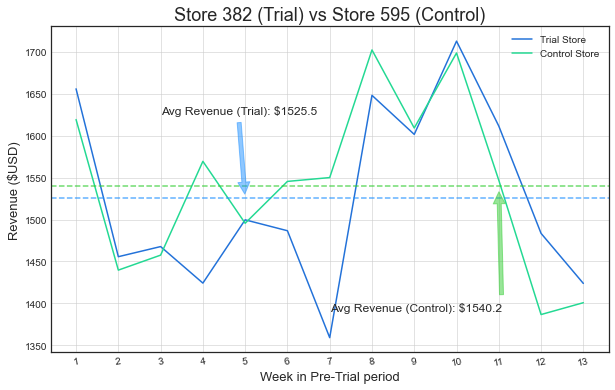

In [26]:
show_comparison_plot(trial_store_zero_compare, 'Store 382 Revenue', 'Store 595 Revenue',
                    'Store 382 (Trial) vs Store 595 (Control)')

# Select Cluster One Control Store
- The trial store number is 528.

In [27]:
trial_store_data

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,382,1656.16,1455.67,1467.76,1424.14,1499.70,1486.68,1358.98,1648.40,1601.75,1713.10,1611.70,1483.53,1423.76
1,528,1110.99,937.21,1101.51,1067.19,955.40,917.08,1014.10,1050.49,928.44,974.68,894.57,911.17,880.77
2,511,1290.36,1248.46,1163.26,1287.34,1160.28,1159.02,1217.96,1321.20,1304.37,1243.14,1164.17,1201.23,1032.10


In [28]:
find_control_store(1, 528, clusterOne)

Store with closest euclidean distance to trial store 528: Store 591
----------------------------


In [29]:
# Concat the two stores
trial_store_one_compare = concat_2_stores(1, clusterOne, 591, 528)
trial_store_one_compare

,Store 528 Revenue,Store 591 Revenue
1,1110.99,1156.05
2,937.21,1028.28
3,1101.51,992.39
4,1067.19,930.30
5,955.40,821.30
6,917.08,842.13
7,1014.10,984.10
8,1050.49,967.17
9,928.44,970.56
10,974.68,940.33


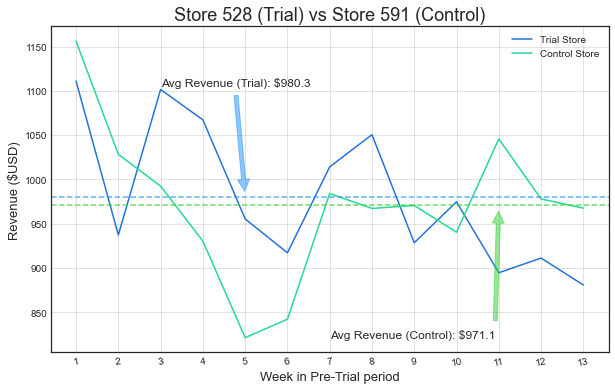

In [36]:
show_comparison_plot(trial_store_one_compare, 'Store 528 Revenue', 'Store 591 Revenue',
                    'Store 528 (Trial) vs Store 591 (Control)')

# Select Cluster Two Control
- The trial store is 511.

In [37]:
trial_store_data

,Store ID,1,2,3,4,5,6,7,8,9,10,11,12,13
0,382,1656.16,1455.67,1467.76,1424.14,1499.70,1486.68,1358.98,1648.40,1601.75,1713.10,1611.70,1483.53,1423.76
1,528,1110.99,937.21,1101.51,1067.19,955.40,917.08,1014.10,1050.49,928.44,974.68,894.57,911.17,880.77
2,511,1290.36,1248.46,1163.26,1287.34,1160.28,1159.02,1217.96,1321.20,1304.37,1243.14,1164.17,1201.23,1032.10


In [38]:
# Find control store
find_control_store(2, 511, clusterTwo)

Store with closest euclidean distance to trial store 511: Store 637
----------------------------


In [40]:
# Concat the two stores
trial_store_two_compare = concat_2_stores(2, clusterTwo, 637, 511)
trial_store_two_compare

,Store 511 Revenue,Store 637 Revenue
1,1290.36,1305.17
2,1248.46,1206.85
3,1163.26,1278.15
4,1287.34,1251.48
5,1160.28,1224.14
6,1159.02,1055.33
7,1217.96,1176.69
8,1321.20,1313.75
9,1304.37,1275.69
10,1243.14,1232.01


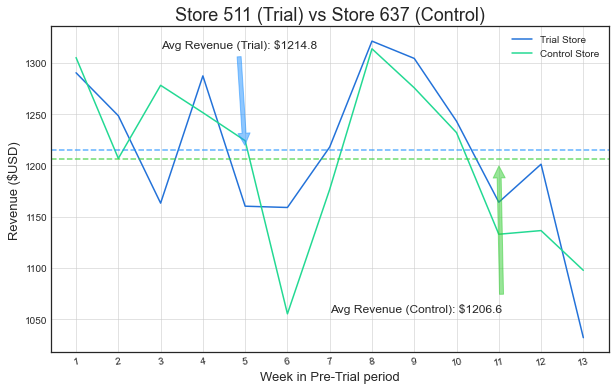

In [43]:
show_comparison_plot(trial_store_two_compare, 'Store 511 Revenue', 'Store 637 Revenue',
                    'Store 511 (Trial) vs Store 637 (Control)')

# Conclusion

- From the trial stores of 382, 528 and 511 for clusters zero, one and two, we were able to find suitable control stores by calculating the stores with the closest vectors via euclidean distance.
-----------------------------------------------------------------

- This results in the following control stores:
-----------------------------------------------------------------
    - ClusterZero: Trial(382) | Control(595)
    - ClusterOne:  Trial(528) | Control(591)
    - ClusterTwo:  Trial(511) | Control(637)
    
-----------------------------------------------------------------
Should the parameters of the experiment change, this process is reproducable and will result in similarly reliable results. For example, should the experiment require multiple trial/control stores per cluster, we can select multiple trial stores which are closest to the average of the centroid, and repeat the process for each trial store set in each cluster to find their corresponding control stores.

However, this experiment cannot be reliable if multiple control stores are chosen for one trial store. If there is a cluster which only has x amount of suitable control stores to the trial store, the algorithm will calculate x amount of control stores, one of which may be an outlier, thus skewing the aggregating result of the A/B test.

### Next Steps
To move on to question 3, we can use the selected control and trial stores to perform an A/B test. Despite being given the control and trial list, we can assume this method outlined in this notebook is just as reliable at finding suitable control stores.